In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math

create dict of run:pval for p and p:stat for c and l

cvals, lvals = [], []
for p in runs[run]:
    for c in cdict:
        cval = np.mean(cdict[p])
        cvals.append(cval)
    for l in ldict:
        lval = np.mean(ldict[p])
        lvals.append(lval)

getting every p-value from the run:value dict then, for each of those values, getting a list of its values in the p:stat dict

must create a new dict of p:avgstat

must first create dicts runs, ldict, and cdict
-- do this in loop
for each run of inner loop, append dicts

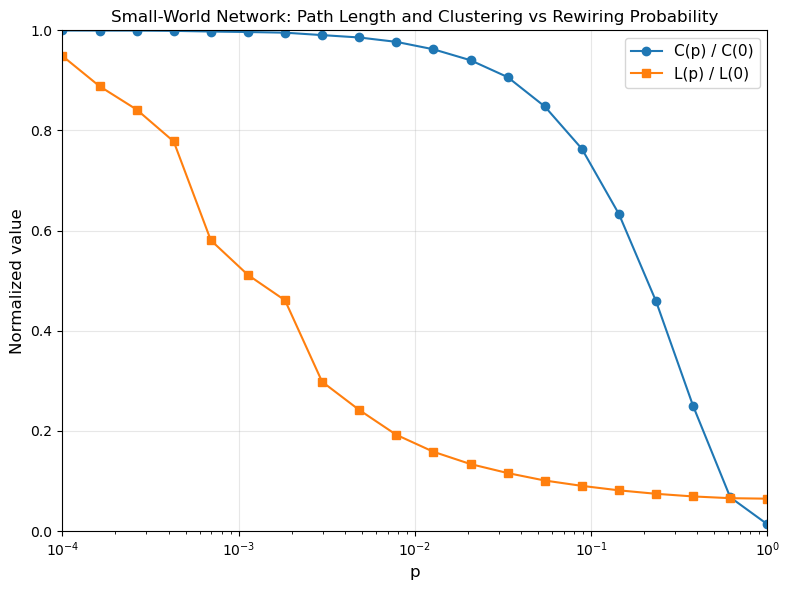

In [12]:
# 1

# getting L(0) and C(0)
normalizer = nx.watts_strogatz_graph(1000, 10, 0)
C0 = nx.average_clustering(normalizer)
L0 = nx.average_shortest_path_length(normalizer)

# storage for trials
pspace = np.logspace(-4, 0, 20)
cdict = {p: [] for p in pspace}
ldict = {p: [] for p in pspace}

for i in range(1, 21): # all trials to average over
    for p in pspace: # getting correct p values
        G = nx.watts_strogatz_graph(1000, 10, p)
        cdict[p].append(nx.average_clustering(G) / C0)
        ldict[p].append(nx.average_shortest_path_length(G) / L0)

# list of averaged values
cvals = [np.mean(cdict[p]) for p in pspace]
lvals = [np.mean(ldict[p]) for p in pspace]
# list of p values
pvals = list(pspace)

# plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(pvals, cvals, 'o-', label='C(p) / C(0)', markersize=6)
ax.plot(pvals, lvals, 's-', label='L(p) / L(0)', markersize=6)

ax.set_xscale('log')
ax.set_xlabel('p', fontsize=12)
ax.set_ylabel('Normalized value', fontsize=12)
ax.set_xlim(1e-4, 1)
ax.set_ylim(0, 1)
ax.legend(fontsize=11)
ax.set_title('Small-World Network: Path Length and Clustering vs Rewiring Probability')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(r'.\imgs\watts_strogatz_figure2.png', dpi=150)
plt.show()

<Figure size 1000x600 with 0 Axes>

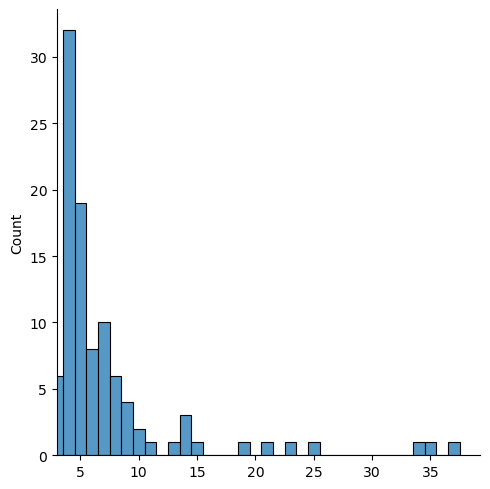

<Figure size 1000x600 with 0 Axes>

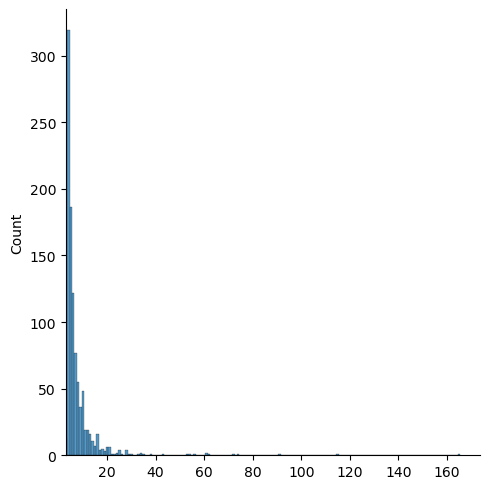

<Figure size 1000x600 with 0 Axes>

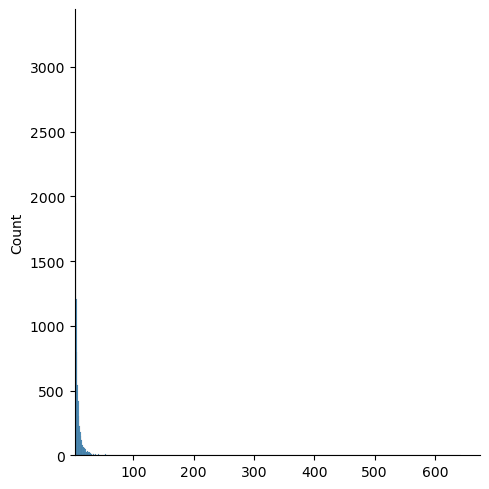

In [ ]:
# 3i

def ba_generator(N, m, plot=None):
    '''
    Implements Barabasi-Albert graph generation method, beginning with a complete
    graph of size 4
    
    :param N (int): Size of resulting network
    :param m (int): Number of new nodes to connect to at each time step
    :param plot (string): Name of file or else will not plot figure

    returns: G (nx.Graph): Generated network
    '''
    G = nx.complete_graph(4)

    # create list of nodes and make them repeat the same number of times as their degree
    attachment_pool = []
    for node, deg in G.degree():
        attachment_pool.extend([node] * deg)

    size = len(G.nodes())
    while size < N:
        # pick m targets from pool (more entries for higher-degree nodes)
        selected_nodes = random.sample(attachment_pool, m)
        
        G.add_node(size) # named so that it doesn't overwrite itself
        for s_node in selected_nodes:
            G.add_edge(size, s_node)
            # update pool
            attachment_pool.append(size)
            attachment_pool.append(s_node)
            
        size += 1

    if plot != None:
        # plot distribution
        plt.figure(figsize=(10,6))
        degrees = [val for (node, val) in G.degree()] # list of degrees
        distplot = sns.displot(degrees, discrete=True)
        plt.xlim(min(degrees), None)
        plt.savefig(f'.\\imgs\\{plot}.png', dpi=150)

    return G

ten_two = ba_generator(pow(10, 2), 4, plot="100dist")
ten_three = ba_generator(pow(10, 3), 4, plot='1000dist')
ten_four = ba_generator(pow(10, 4), 4, plot='10000dist')

In [ ]:
# 3ii (come back later)

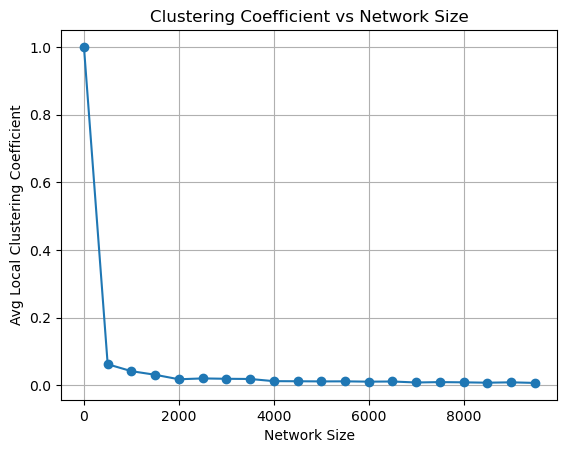

In [49]:
# 3iii

Ns = []
clustering_vals = []

for N in range(1, 10000, 500):
    G = ba_generator(N, 4)
    clustering_vals.append(nx.average_clustering(G))
    Ns.append(N)

plt.plot(Ns, clustering_vals, marker='o')
plt.xlabel('Network Size')
plt.ylabel('Avg Local Clustering Coefficient')
plt.title('Clustering Coefficient vs Network Size')
plt.grid(True)
plt.savefig(r'.\imgs\clustering_vs_size.png')
plt.show()

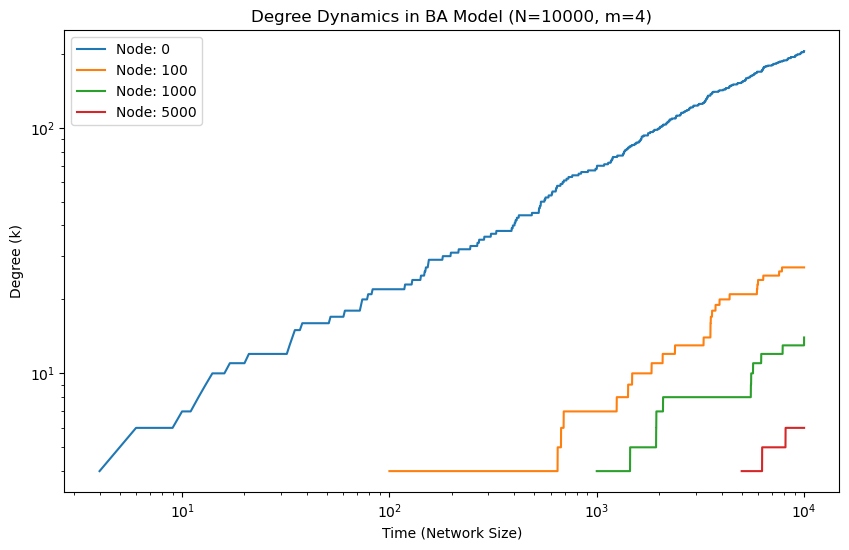

In [54]:
# 3iv

def ba_tracker(N, m):
    '''
    Implements Barabasi-Albert model for tracking the evolution of specific nodes 
    (at t=1, 100, 1000, and 5000) as graph expands
    
    :param N (int): Size of resulting network
    :param m (int): Number of new nodes to connect to at each time step
    '''
    G = nx.complete_graph(4)

    # dict of nodes to track and list of their values
    tracking_dict = {0:[], 100:[], 1000:[], 5000:[]}

    # create list of nodes and make them repeat the same number of times as their degree
    attachment_pool = []
    for node, deg in G.degree():
        attachment_pool.extend([node] * deg)

    size = len(G.nodes())
    t = 0 # init time counter

    while size < N:
        # pick m targets from pool (more entries for higher-degree nodes)
        selected_nodes = random.sample(attachment_pool, m)

        G.add_node(size)

        for s_node in selected_nodes:
            G.add_edge(size, s_node)
            # update pool
            attachment_pool.append(size)
            attachment_pool.append(s_node)

        # updating dict
        for node in tracking_dict:
            if G.has_node(node):
                tracking_dict[node].append(G.degree(node))
            else:
                tracking_dict[node].append(None) # not "born" yet
 
        size += 1
        t += 1

    # plotting
    plt.figure(figsize=(10, 6))
    
    for node, history in tracking_dict.items():
        # filter out values for nodes not yet created
        clean_history = [h for h in history if h is not None]
        # x axis is the time step where the node was active
        time_axis = range(N - len(clean_history), N)
        
        plt.plot(time_axis, clean_history, label=f'Node: {node}')

    plt.title(f"Degree Dynamics in BA Model (N={N}, m={m})")
    plt.xlabel("Time (Network Size)")
    plt.ylabel("Degree (k)")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig(r'./imgs/degree_dynamics.png')

ba_tracker(10000, 4)

In [13]:
# 3b optimization model creation

def o_model(N, delta):
    ''' 
    Implements optimization model for generating preferential attachment networks using 
    spatial distance.

    Args:
    N (int): Number of nodes in the final network. Also determines the number of
    timesteps.
    delta (float or int): Cost-per-distance parameter

    Returns:
    G (nx.Graph()): Generated network
    '''
    G = nx.complete_graph(2) # to avoid infinite path length error

    # create minimum coordinate space that can fit all nodes by taking the ceiling of the sqrt of N
    dim = math.ceil(math.sqrt(N))

    # shuffle so i can just index into it instead of randomizing every time
    coords = [(x, y) for x in range(dim) for y in range(dim)]
    random.shuffle(coords)

    # defining first node and assigning to variable, also adding attributes
    for node in G.nodes():
        G.nodes[node]['loc'] = coords[node]

    root_node = 0

    # helper function to define cost function
    def cost(i, j):
        dist = math.dist(G.nodes[i]['loc'], G.nodes[j]['loc'])
        path_len = nx.shortest_path_length(G, source=root_node, target=j)
        return (delta * dist) + path_len
    
    size = len(G.nodes())
    while size < N:
        i = size
        G.add_node(i, loc = coords[i])
        # finding minimum of cost function
        best_j = min((j for j in G.nodes() if j != i), key=lambda j: cost(i, j))
        G.add_edge(i, best_j)
        size += 1

    return G
        
point1 = o_model(1000, .1)
ten = o_model(1000, 10)
thousand = o_model(1000, 1000)

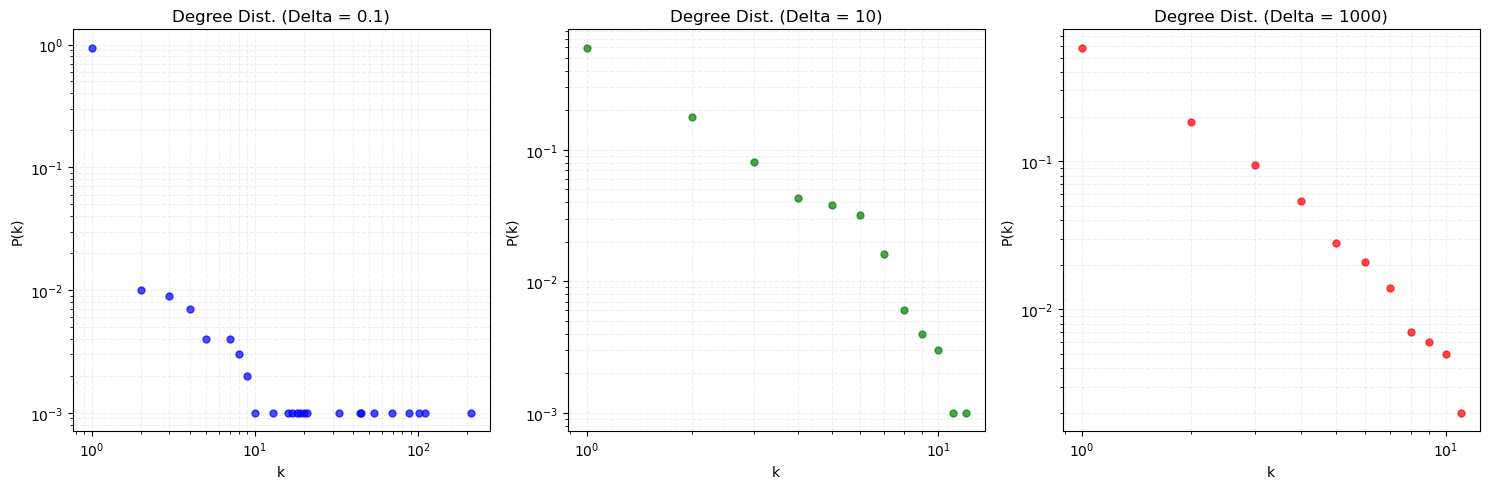

In [17]:
# 3c plots

def plot_degree_distributions(graphs, labels):
    plt.figure(figsize=(15, 5))
    
    # Colors for distinction
    colors = ['blue', 'green', 'red']
    
    for i, (G, label) in enumerate(zip(graphs, labels)):
        plt.subplot(1, 3, i+1)
        
        # get degrees and calculate distribution
        degrees = [d for n, d in G.degree()]
        
        # use numpy to get unique values and counts
        k_values, counts = np.unique(degrees, return_counts=True)
        
        # normalize counts to get probability P(k)
        Pk = counts / sum(counts)
        
        # log-log scale
        plt.loglog(k_values, Pk, 'o', color=colors[i], markersize=5, alpha=0.7)
        
        # formatting
        plt.title(f"Degree Dist. (Delta = {label})")
        plt.xlabel("k")
        plt.ylabel("P(k)")
        plt.grid(True, which="both", ls="--", alpha=0.2)
        
    plt.tight_layout()
    plt.savefig(r'.\imgs\o_model_degdist.png')
    plt.show()

graphs_list = [point1, ten, thousand]
labels_list = [0.1, 10, 1000]

plot_degree_distributions(graphs_list, labels_list)

In [ ]:
# 3d link-selection and copying

def ls_model():
    pass

def c_model()

each node is optimizing its own position as it arrives in the network. so for each node added, it uses the function to identify which node it will connect to. nodes are initialized with a location in a physical space. it chooses the node j that minimizes this function out of the set of all nodes. for each j, the function multiplies the distance between it and the new node by a constant delta that represents the "cost per unit distance," then adds this to node j's distance from the first node in the network.

so first i will need to create a physical 2d space for the nodes to be given locations in. then i run it like the other pref attachment model with necessary modifications

minimum multipliers that will create a certain number